**SOC predition SDBMS FNN**

Battery : **LG 18650HG2 Li-ion**

Cell Capacity : **3.0**Ah (Ampere Hour)

Max Voltage : **4.2**v

Application: **EV Battery Cell**

Install Required Package

In [38]:
!pip install pandas scikit-learn tensorflow seaborn


Load Required Python Package

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

Load data set to the dataframe and remove unnecessary coloumn

In [2]:
import pandas as pd
dataSetLocation = "./datasets/610_UDDS.csv"
dataFrame = pd.read_csv(dataSetLocation, skiprows=0)
dataFrame = dataFrame.drop('Step', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Status', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Time Stamp', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Step Time', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Cycle', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Cycle Level', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Procedure', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Capacity', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('WhAccu', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('Cnt', axis=1).reset_index(drop=True)
dataFrame = dataFrame.loc[:, ~dataFrame.columns.str.contains('^Unnamed')]


print dataFrame dimension

In [3]:
print(dataFrame.head())
print(dataFrame.tail())
print(dataFrame.shape)

      Prog Time  Voltage  Current  Temperature
0  05:59:00.850  4.18312 -0.04342    -19.87496
1  05:59:00.952  4.17722 -0.08173    -19.87496
2  05:59:01.047  4.17419 -0.09195    -19.87496
3  05:59:01.149  4.17166 -0.09450    -19.87496
4  05:59:01.251  4.16964 -0.09450    -19.87496
          Prog Time  Voltage  Current  Temperature
81906  08:15:31.404  3.59666      0.0    -19.66465
81907  08:15:31.501  3.59666      0.0    -19.66465
81908  08:15:31.603  3.59666      0.0    -19.66465
81909  08:15:31.705  3.59666      0.0    -19.66465
81910  08:15:31.705  3.59666      0.0    -19.66465
(81911, 4)


Compute Battery SOC (State of Charge) using Coulomb Counting

In [4]:
# Convert
dataFrame['Prog Time'] = pd.to_datetime(dataFrame['Prog Time'], format="%H:%M:%S.%f")
dataFrame['Current'] = pd.to_numeric(dataFrame['Current'], errors='coerce').fillna(0)
dataFrame['Voltage'] = pd.to_numeric(dataFrame['Voltage'], errors='coerce').fillna(0)
dataFrame['Temperature'] = pd.to_numeric(dataFrame['Temperature'], errors='coerce').fillna(0)

# determine timediff
dataFrame['TimeDiff'] = dataFrame['Prog Time'].diff().dt.total_seconds().fillna(0)

battery_capacity = 3
# Coulomb Counting | Current default is negative
dataFrame['CapacityDiff'] = (dataFrame['Current'].astype(float) * (dataFrame['TimeDiff'] / 3600))

# Initialize SOC column
soc_list = []

for i in range(len(dataFrame)):
    if i == 0:
        soc_list.append(1.0)  # Start at 100%
    else:
        coulombCountingSOC = soc_list[i-1] + (dataFrame['CapacityDiff'][i]/battery_capacity) 
        soc_list.append(coulombCountingSOC)

dataFrame['SOC'] = soc_list

In [5]:
print(dataFrame.head())
print(dataFrame.tail())

                Prog Time  Voltage  Current  Temperature  TimeDiff  \
0 1900-01-01 05:59:00.850  4.18312 -0.04342    -19.87496     0.000   
1 1900-01-01 05:59:00.952  4.17722 -0.08173    -19.87496     0.102   
2 1900-01-01 05:59:01.047  4.17419 -0.09195    -19.87496     0.095   
3 1900-01-01 05:59:01.149  4.17166 -0.09450    -19.87496     0.102   
4 1900-01-01 05:59:01.251  4.16964 -0.09450    -19.87496     0.102   

   CapacityDiff       SOC  
0     -0.000000  1.000000  
1     -0.000002  0.999999  
2     -0.000002  0.999998  
3     -0.000003  0.999998  
4     -0.000003  0.999997  
                    Prog Time  Voltage  Current  Temperature  TimeDiff  \
81906 1900-01-01 08:15:31.404  3.59666      0.0    -19.66465     0.102   
81907 1900-01-01 08:15:31.501  3.59666      0.0    -19.66465     0.097   
81908 1900-01-01 08:15:31.603  3.59666      0.0    -19.66465     0.102   
81909 1900-01-01 08:15:31.705  3.59666      0.0    -19.66465     0.102   
81910 1900-01-01 08:15:31.705  3.59666   

Drop Unnecesary feature column before training

In [6]:
dataFrame = dataFrame.drop('Prog Time', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('TimeDiff', axis=1).reset_index(drop=True)
dataFrame = dataFrame.drop('CapacityDiff', axis=1).reset_index(drop=True)


Check Mean,Median,Mode, Quartile, Standard Deviation

        Column       Mean     Median       Mode         Q1         Q3  \
0      Voltage   3.678124   3.683300   4.199950   3.537660   3.849210   
1      Current  -0.697287  -0.183890   0.000000  -1.366440   0.000000   
2  Temperature -19.119000 -19.244010 -19.349170 -19.454330 -18.823380   
3          SOC   0.717994   0.729563   0.471165   0.575432   0.851945   

    Std Dev  
0  0.248106  
1  1.441586  
2  0.426491  
3  0.158151  


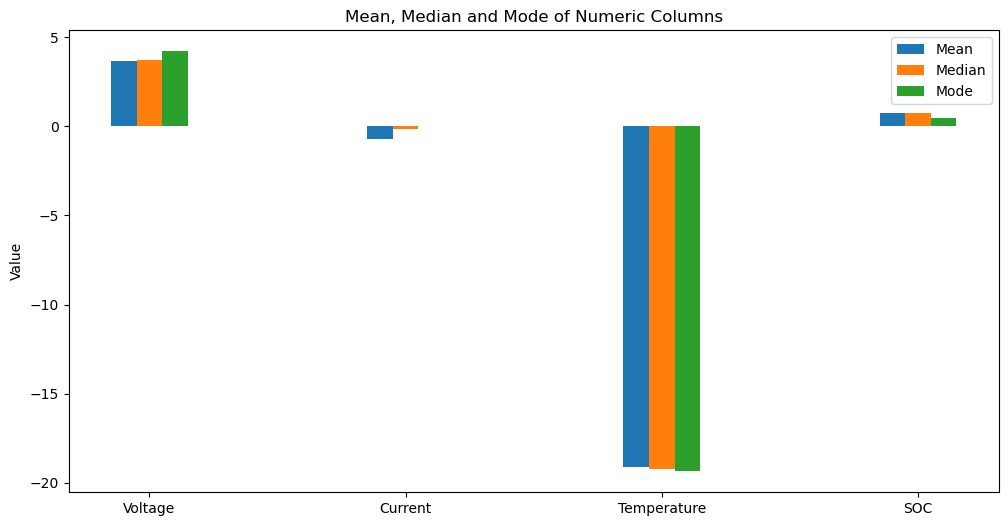

In [7]:
numeric_cols = dataFrame.select_dtypes(include=['number']).columns

stats_list = []
for col in numeric_cols:
    stats = {
        'Column': col,
        'Mean': dataFrame[col].mean(),
        'Median': dataFrame[col].median(),
        'Mode': dataFrame[col].mode().values[0] if not dataFrame[col].mode().empty else None,
        'Q1': dataFrame[col].quantile(0.25),
        'Q3': dataFrame[col].quantile(0.75),
        'Std Dev': dataFrame[col].std()
    }
    stats_list.append(stats)

descriptiveStatisticDataFrame = pd.DataFrame(stats_list)
print(descriptiveStatisticDataFrame)

# Visualize
x = np.arange(len(descriptiveStatisticDataFrame['Column']))  # label locations
width = 0.1  

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width, descriptiveStatisticDataFrame['Mean'], width, label='Mean')
ax.bar(x, descriptiveStatisticDataFrame['Median'], width, label='Median')
ax.bar(x + width, descriptiveStatisticDataFrame['Mode'], width, label='Mode')

ax.set_xticks(x)
ax.set_xticklabels(descriptiveStatisticDataFrame['Column'])
ax.set_ylabel('Value')
ax.set_title('Mean, Median and Mode of Numeric Columns')
ax.legend()

plt.show()

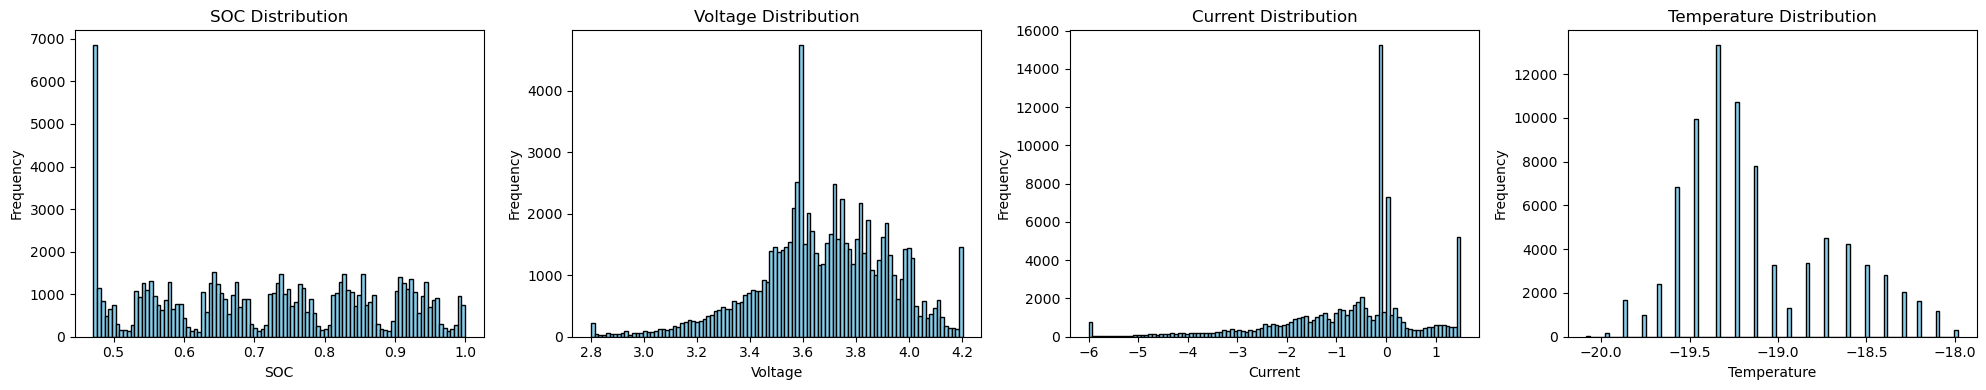

In [8]:
features = ["SOC", "Voltage", "Current",  "Temperature"]
num_features = len(features)

plt.figure(figsize=(5 * num_features, 4))

for i, feature in enumerate(features):
    plt.subplot(1, num_features, i + 1)
    plt.hist(dataFrame[feature], bins=100, color="skyblue", edgecolor="black")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"{feature} Distribution")

plt.tight_layout()
plt.show()


Split X (Feature: Current, Voltage, CapacityDiff, BatteryCapacity) and Y (target: SOC)

In [9]:
Y = dataFrame['SOC']
X = dataFrame.drop('SOC', axis=1).reset_index(drop=True)
print(X)
print(Y)

       Voltage  Current  Temperature
0      4.18312 -0.04342    -19.87496
1      4.17722 -0.08173    -19.87496
2      4.17419 -0.09195    -19.87496
3      4.17166 -0.09450    -19.87496
4      4.16964 -0.09450    -19.87496
...        ...      ...          ...
81906  3.59666  0.00000    -19.66465
81907  3.59666  0.00000    -19.66465
81908  3.59666  0.00000    -19.66465
81909  3.59666  0.00000    -19.66465
81910  3.59666  0.00000    -19.66465

[81911 rows x 3 columns]
0        1.000000
1        0.999999
2        0.999998
3        0.999998
4        0.999997
           ...   
81906    0.471165
81907    0.471165
81908    0.471165
81909    0.471165
81910    0.471165
Name: SOC, Length: 81911, dtype: float64


### Split 0.25 for test, 0.75 for training

Normalize

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=66)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "./scaler/soc_minmax_scaler_new.pkl")

['./scaler/soc_minmax_scaler_new.pkl']

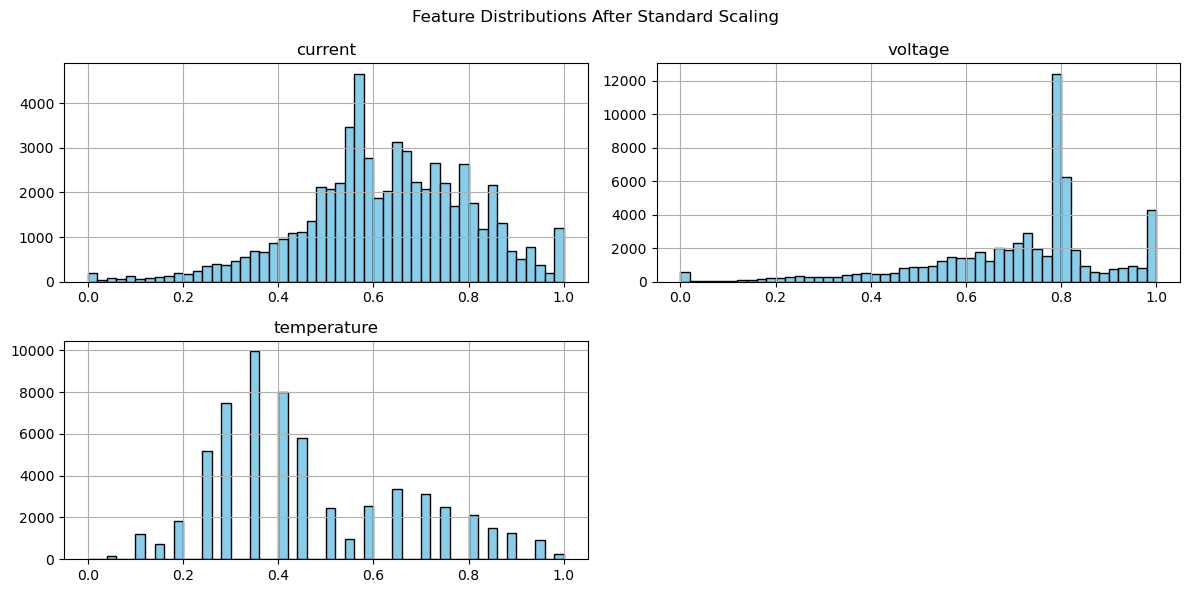

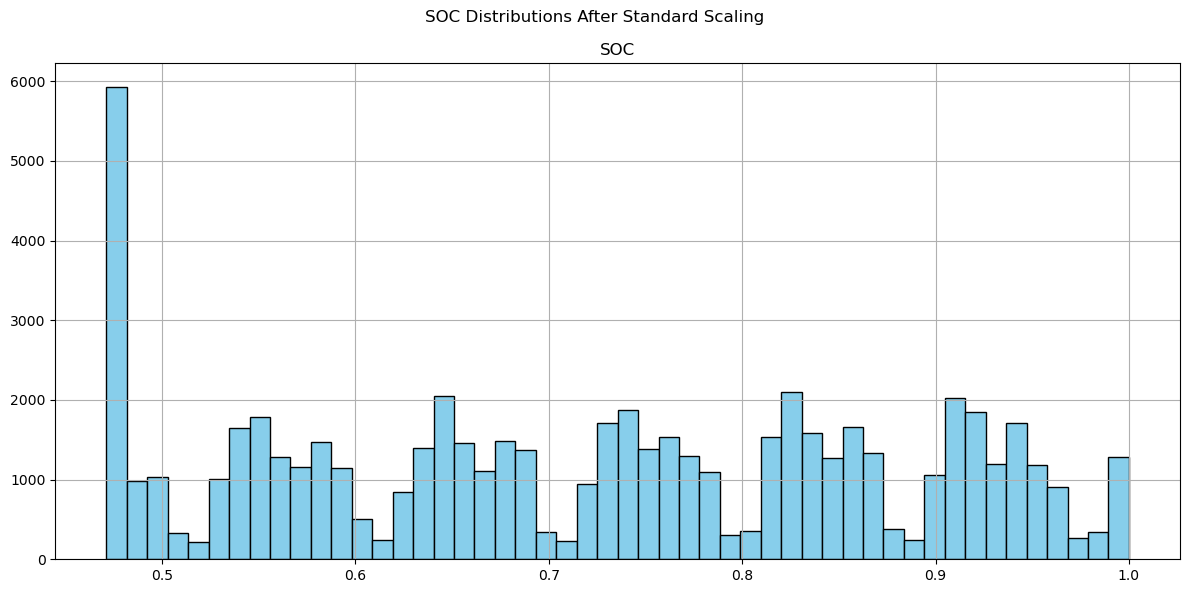

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

scaled_df = pd.DataFrame(X_train, columns=["current", "voltage", "temperature"]) 

scaled_df.hist(bins=50, figsize=(12, 6), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions After Standard Scaling")
plt.tight_layout()
plt.show()

scaled_df_label = pd.DataFrame(Y_train, columns=["SOC"])  # Use your actual feature names

scaled_df_label.hist(bins=50, figsize=(12, 6), color="skyblue", edgecolor="black")
plt.suptitle("SOC Distributions After Standard Scaling")
plt.tight_layout()
plt.show()

Train & Evaluate using TensorFlow

In [13]:
%%time
# Forward Neural network Model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),  
    tf.keras.layers.Dense(16, activation='relu'),                            
    tf.keras.layers.Dense(1, activation='linear')  # last layer = linear to predict SOC (single target number)                         
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X_train, Y_train, epochs=150, batch_size=32, validation_split=0.25, verbose=1)

# Predict on the test set
Y_pred = model.predict(X_test)

Epoch 1/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - loss: 0.0568 - mae: 0.1276 - val_loss: 0.0018 - val_mae: 0.0303
Epoch 2/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 0.0019 - mae: 0.0314 - val_loss: 0.0020 - val_mae: 0.0315
Epoch 3/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - loss: 0.0019 - mae: 0.0312 - val_loss: 0.0017 - val_mae: 0.0293
Epoch 4/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 0.0017 - mae: 0.0302 - val_loss: 0.0016 - val_mae: 0.0287
Epoch 5/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 0.0017 - mae: 0.0295 - val_loss: 0.0015 - val_mae: 0.0280
Epoch 6/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - loss: 0.0016 - mae: 0.0289 - val_loss: 0.0015 - val_mae: 0.0264
Epoch 7/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0014 - val_mae: 0.0259
Epoch 8/150
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 9/150
1440

Plot Actual Vs Predicted SOC and Display MAE, MSE and R2

Mean Squared Error (MSE): 0.0010681547221843997
Mean Absolute Error (MAE): 0.02196912853537038
R² Score: 0.9574083417745312


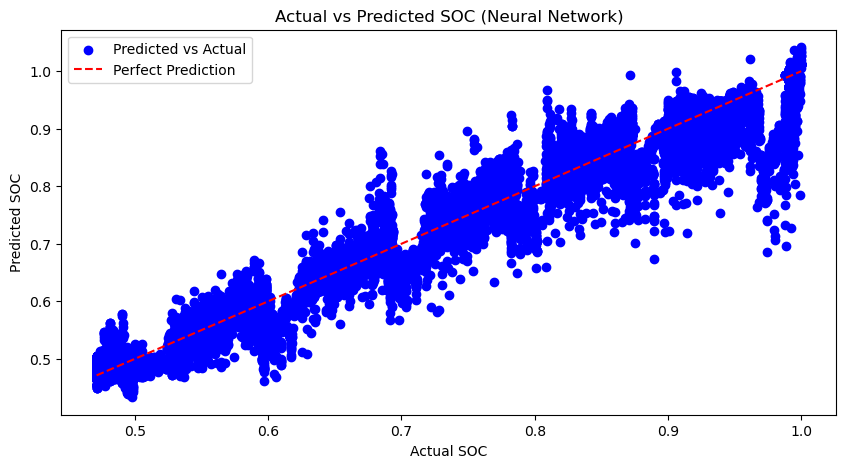

In [73]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)


# Output the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(Y_test, Y_pred, color='blue', label='Predicted vs Actual')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', linestyle='--', label='Perfect Prediction')  # diagonal
plt.xlabel("Actual SOC")
plt.ylabel("Predicted SOC")
plt.title("Actual vs Predicted SOC (Neural Network)")
plt.legend()
plt.show()


Export Model

In [77]:
model.save("./model/soc_prediction_model.keras")